## 1. 데이터 분석 및 전처리

In [1]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor

# matplotlib 한글 폰트 설정
plt.rc('font', family='AppleGothic')

warnings.filterwarnings('ignore')

In [2]:
# 1. 데이터 로드 및 확인
file_path = '/Users/yujunwon/Work/customer_data_.csv'

df = pd.read_csv(file_path, encoding='cp949')
df.tail()

,clust,AGE,등록(계/피),고용상태,성별,Willingness to pay/Stay,갱신,상품타입,교육수준,소득,...,결혼여부,월 납입액,VOC,타 상품 보유 현황,온라인방문빈도,갱신인센티브,판매채널,총지불금액,자동차,거주지사이즈
11995,0,1,계약자,고용,1,25.9851,0,기본,대학졸업,86451000,...,기혼,70000,0,2,비방문,설계사독려,인터넷,245000,일반세단,중
11996,0,3,피보험자,고용,0,3.4410,1,중급,대학졸업,25962000,...,미혼,80000,0,1,자주방문,할인,자사영업,468000,일반세단,중
11997,2,3,피보험자,무직,1,9.0576,0,중급,대학졸업,0,...,미혼,90000,3,2,자주방문,할인,자사영업,977000,일반세단,중
11998,4,4,계약자,고용,1,8.3472,0,중급,대학졸업,26366000,...,기혼,100000,0,3,비방문,포인트,자사영업,854000,일반세단,대
11999,2,3,피보험자,무직,1,2.8971,0,중급,대학졸업,0,...,미혼,80000,0,1,자주방문,없음,콜센터,456000,컴팩트카,중


In [3]:
# 2. 결측치 확인
missing_values = df.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]

print(columns_with_missing_values)
print("결측치 없습니다.")

Series([], dtype: int64)
결측치 없습니다.


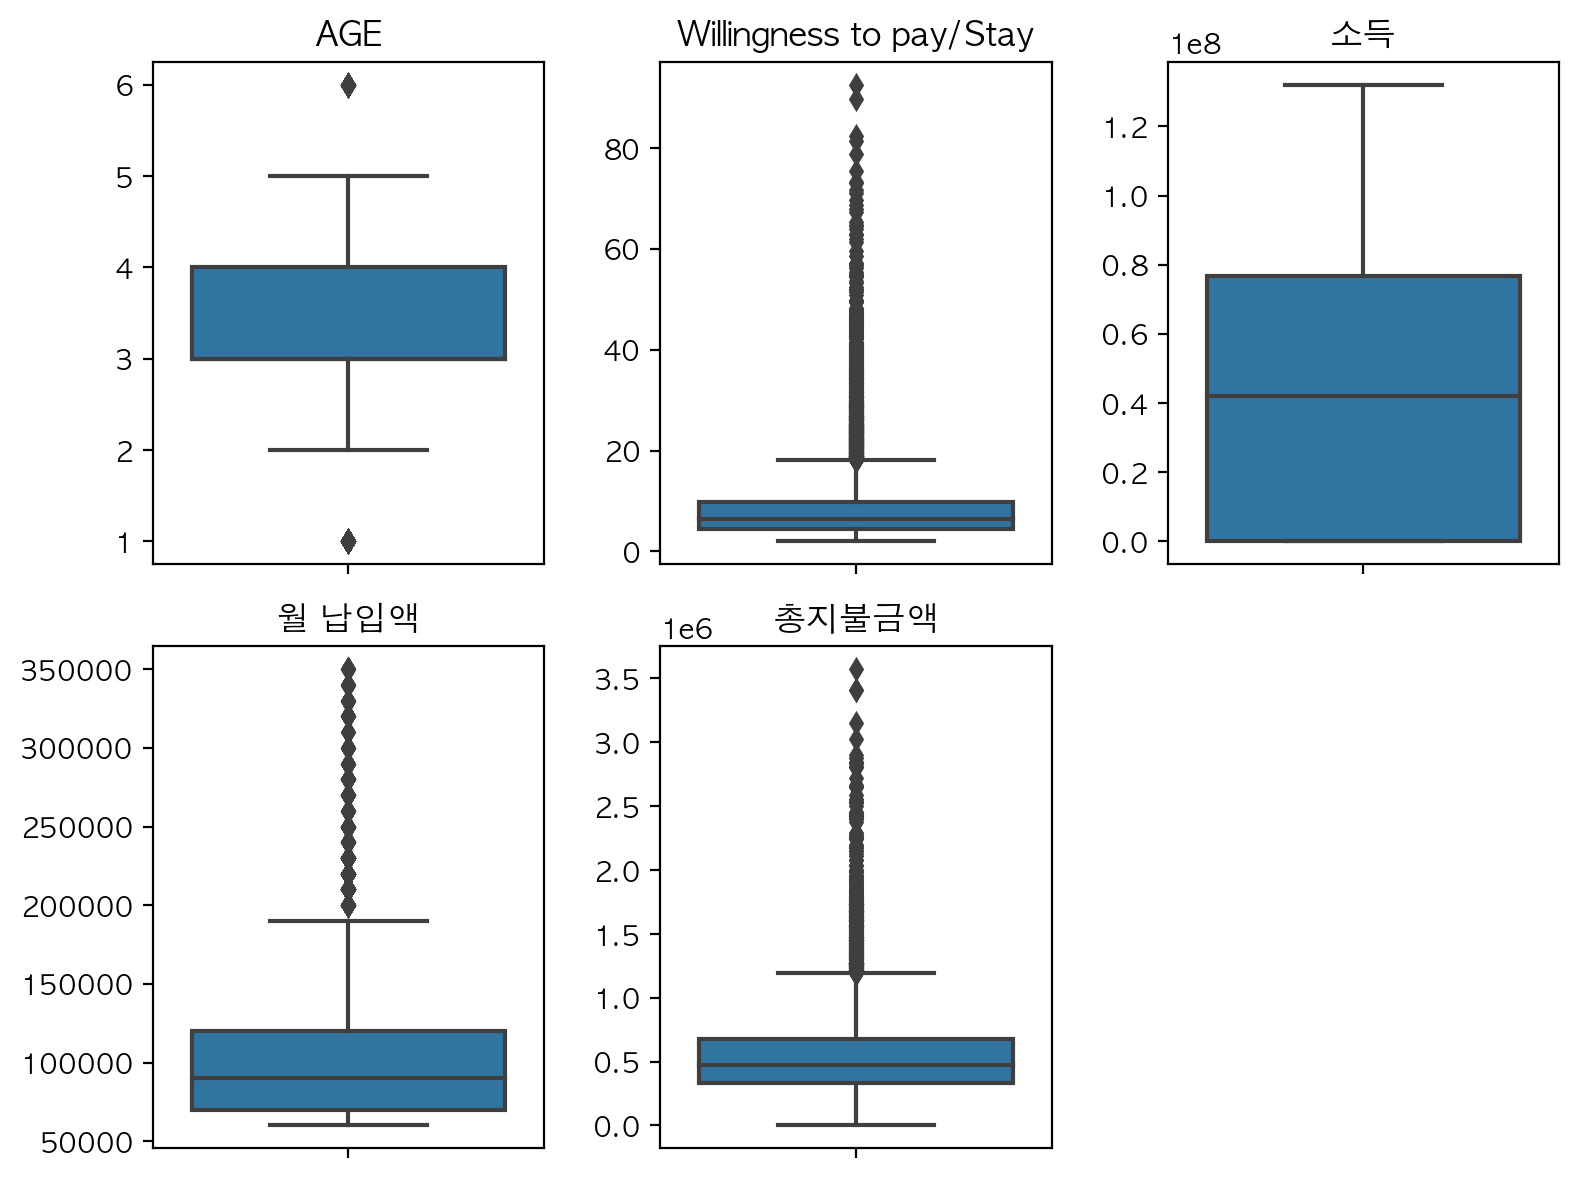

In [4]:
# 3. 수치형 변수 리스트
numerical_columns = ['AGE', 'Willingness to pay/Stay', '소득', '월 납입액', '총지불금액']

plt.figure(figsize=(8, 6))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.ylabel('')

plt.tight_layout()
plt.show()

In [5]:
# 4. 이상치 확인
# IQR(Interquartile Range) 방법을 사용하여 이상치 개수를 계산하는 함수
def count_outliers(data, column_name):
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # lower bound와 upper bound 사이에 있는 값은 이상치가 아님
    outliers_count = ((data[column_name] < lower_bound) | (data[column_name] > upper_bound)).sum()
    
    return outliers_count

# 각각의 수치형 컬럼에서 이상치를 count
outliers_counts = {col: count_outliers(df, col) for col in numerical_columns}
outliers_counts

{'AGE': 1506,
 'Willingness to pay/Stay': 1080,
 '소득': 0,
 '월 납입액': 563,
 '총지불금액': 584}

In [6]:
# AGE 컬럼 수정
df['AGE'] = (df['AGE'] * 10) + 10  # "1: 20대, 2: 30대, 3:40대, 4:50대, ..."를 실제 연령대로 변경

# '타 상품 보유 현황' 컬럼에서 4이상의 값을 4로 변경
df['타 상품 보유 현황'] = df['타 상품 보유 현황'].replace('4이상', '4')          # '4이상' 값을 '4'로 변경
df['타 상품 보유 현황'] = df['타 상품 보유 현황'].astype(int)                   # 문자열을 정수로 변환
df['타 상품 보유 현황'] = df['타 상품 보유 현황'].apply(lambda x: min(x, 4))    # 4이상의 값을 4로 변경

# 수정된 데이터프레임의 처음 몇 행을 출력
df.head()


,clust,AGE,등록(계/피),고용상태,성별,Willingness to pay/Stay,갱신,상품타입,교육수준,소득,...,결혼여부,월 납입액,VOC,타 상품 보유 현황,온라인방문빈도,갱신인센티브,판매채널,총지불금액,자동차,거주지사이즈
0,2,40,피보험자,무직,1,2.616381,0,기본,대학졸업,0,...,미혼,80000,0,1,자주방문,없음,자사영업,631000,일반세단,소
1,4,20,계약자,고용,0,6.352530,0,기본,고졸이하,102887400,...,미혼,80000,1,4,비방문,포인트,인터넷,54000,일반세단,중
2,5,30,계약자,휴직,0,4.974354,0,기본,대학졸업,22159500,...,기혼,60000,0,4,비방문,할인,자사영업,362000,일반세단,중
3,0,60,계약자,고용,1,13.480284,0,고급,고졸이하,51562500,...,기혼,110000,0,2,비방문,할인,자사영업,1264000,컴팩트카,대
4,3,50,계약자,고용,0,9.776436,0,기본,석사,26820200,...,기혼,120000,0,3,비방문,없음,대리점,947000,SUV,중


In [7]:
# 데이터의 전반적 구조
data_info = pd.DataFrame()
data_info['Data Type'] = df.dtypes
data_info['Missing Values'] = df.isnull().sum()
data_info['Unique Values'] = df.nunique()
data_info

,Data Type,Missing Values,Unique Values
clust,int64,0,6
AGE,int64,0,6
등록(계/피),object,0,2
고용상태,object,0,4
성별,int64,0,2
Willingness to pay/Stay,float64,0,3024
갱신,int64,0,2
상품타입,object,0,3
교육수준,object,0,4
소득,int64,0,7641


## 2. 상관관계 분석

In [8]:
# 자료형이 object인 컬럼을 찾고, 수치형으로 변환할 수 있는지 확인
df_corr = df.copy()

object_columns = df_corr.select_dtypes(include=['object']).columns

# object 컬럼에서 unique value를 확인하고, 수치형으로 변환할 수 있는지 확인
object_column_values = {}
for col in object_columns:
    try:
        df_corr[col] = pd.to_numeric(df_corr[col], errors='raise')
    except Exception:
        object_column_values[col] = df_corr[col].unique()

object_column_values

{'등록(계/피)': array(['피보험자', '계약자'], dtype=object),
 '고용상태': array(['무직', '고용', '휴직', 'FALSE'], dtype=object),
 '상품타입': array(['기본', '고급', '중급'], dtype=object),
 '교육수준': array(['대학졸업', '고졸이하', '석사', '박사'], dtype=object),
 '지역': array(['도시근교', '시골', '도심'], dtype=object),
 '결혼여부': array(['미혼', '기혼'], dtype=object),
 '온라인방문빈도': array(['자주방문', '비방문', '종종'], dtype=object),
 '갱신인센티브': array(['없음', '포인트', '할인', '설계사독려'], dtype=object),
 '판매채널': array(['자사영업', '인터넷', '대리점', '콜센터'], dtype=object),
 '자동차': array(['일반세단', '컴팩트카', 'SUV', '스포츠카', '고급차'], dtype=object),
 '거주지사이즈': array(['소', '중', '대'], dtype=object)}

In [9]:
# Define columns to be converted and the corresponding transformation functions
conversion_columns = {
    'Willingness to pay/Stay': lambda x: np.nan if x is np.nan else (float(x.strip('%')) / 100 if isinstance(x, str) else x),
    '소득': lambda x: np.nan if x is np.nan else (int(x.replace(',', '')) if isinstance(x, str) else x),
    '월 납입액': lambda x: np.nan if x is np.nan else (int(x.replace(',', '')) if isinstance(x, str) else x),
    '총지불금액': lambda x: np.nan if x is np.nan else (int(x.replace(',', '')) if isinstance(x, str) else x)
}

# Apply the transformation functions to the corresponding columns
for col, func in conversion_columns.items():
    if df_corr[col].dtype == 'object':  # Check if the column data type is object
        df_corr[col] = df_corr[col].map(func)

df_corr

,clust,AGE,등록(계/피),고용상태,성별,Willingness to pay/Stay,갱신,상품타입,교육수준,소득,...,결혼여부,월 납입액,VOC,타 상품 보유 현황,온라인방문빈도,갱신인센티브,판매채널,총지불금액,자동차,거주지사이즈
0,2,40,피보험자,무직,1,2.616381,0,기본,대학졸업,0,...,미혼,80000,0,1,자주방문,없음,자사영업,631000,일반세단,소
1,4,20,계약자,고용,0,6.352530,0,기본,고졸이하,102887400,...,미혼,80000,1,4,비방문,포인트,인터넷,54000,일반세단,중
2,5,30,계약자,휴직,0,4.974354,0,기본,대학졸업,22159500,...,기혼,60000,0,4,비방문,할인,자사영업,362000,일반세단,중
3,0,60,계약자,고용,1,13.480284,0,고급,고졸이하,51562500,...,기혼,110000,0,2,비방문,할인,자사영업,1264000,컴팩트카,대
4,3,50,계약자,고용,0,9.776436,0,기본,석사,26820200,...,기혼,120000,0,3,비방문,없음,대리점,947000,SUV,중
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0,20,계약자,고용,1,25.985100,0,기본,대학졸업,86451000,...,기혼,70000,0,2,비방문,설계사독려,인터넷,245000,일반세단,중
11996,0,40,피보험자,고용,0,3.441000,1,중급,대학졸업,25962000,...,미혼,80000,0,1,자주방문,할인,자사영업,468000,일반세단,중
11997,2,40,피보험자,무직,1,9.057600,0,중급,대학졸업,0,...,미혼,90000,3,2,자주방문,할인,자사영업,977000,일반세단,중
11998,4,50,계약자,고용,1,8.347200,0,중급,대학졸업,26366000,...,기혼,100000,0,3,비방문,포인트,자사영업,854000,일반세단,대


In [10]:
# 남아있는 object 타입의 열들을 원-핫 인코딩
data_encoded = pd.get_dummies(df_corr, columns=[col for col in object_columns if col not in conversion_columns])

# 변환된 데이터 확인
data_encoded.head()

# 상관 관계 행렬 계산
correlation_matrix = data_encoded.corr()

# "Willingness to pay/Stay" 열과의 상관 관계 값을 추출
wtp_correlation = correlation_matrix['Willingness to pay/Stay'].drop('Willingness to pay/Stay')

# "Willingness to pay/Stay"와 절대 상관 관계가 가장 높은 열 찾기
max_corr_column = wtp_correlation.abs().idxmax()
max_corr_value = wtp_correlation[max_corr_column]

max_corr_column, max_corr_value

('월 납입액', 0.39182727428367115)

In [11]:
# "월 납입액" 열과 다른 모든 열 간의 상관 관계 값을 추출
monthly_payment_correlation = correlation_matrix['월 납입액'].drop('월 납입액')

# "월 납입액"과 절대 상관 관계가 가장 높은 열 찾기
max_corr_column_payment = monthly_payment_correlation.abs().idxmax()
max_corr_value_payment = monthly_payment_correlation[max_corr_column_payment]

max_corr_column_payment, max_corr_value_payment

('자동차_고급차', 0.6867684497216702)

In [12]:
# 변환된 "판매채널" 열들을 추출
sales_channel_columns = [col for col in data_encoded.columns if '판매채널' in col]

# 각 "판매채널" 열과 절대 상관 관계가 가장 높은 열 찾기
max_corr_sales_channel = {}
for col in sales_channel_columns:
    column_correlation = correlation_matrix[col].drop(col)
    max_corr_column = column_correlation.abs().idxmax()
    max_corr_value = column_correlation[max_corr_column]
    max_corr_sales_channel[col] = {'column': max_corr_column, 'value': max_corr_value}

max_corr_sales_channel

{'판매채널_대리점': {'column': '판매채널_자사영업', 'value': -0.48986326254258433},
 '판매채널_인터넷': {'column': '판매채널_대리점', 'value': -0.3242286564158329},
 '판매채널_자사영업': {'column': '판매채널_대리점', 'value': -0.48986326254258433},
 '판매채널_콜센터': {'column': '판매채널_대리점', 'value': -0.38533700462276743}}

- `Willingness to pay/Stay`와 가장 상관관계가 높은 컬럼은 `월 납입액`이다.(0.39) → 월 납입액이 높을 수록 계약 유지율이 높다.
- `월 납입액`와 가장 상관관계가 높은 컬럼은 `자동차_고급차`이다.(0.69) → 고급차를 소유하고 있을수록 월 납입액이 많다.
- `판매채널`에서 대리점이 다른 요소보다 음의 상관관계가 높다.

## 다중 공선성 파악

In [13]:
object_columns = df_corr.select_dtypes(include=['object']).columns
df_corr = pd.get_dummies(df_corr, columns=object_columns, drop_first=True)

numeric_data = df_corr.select_dtypes(exclude=["object"])
vif_data = pd.DataFrame()
vif_data["VIF Factor"] = [variance_inflation_factor(numeric_data.values, i) 
                          for i in range(numeric_data.shape[1])]
vif_data["features"] = numeric_data.columns
vif_data = vif_data.sort_values("VIF Factor", ascending=False).reset_index(drop=True)

vif_data

,VIF Factor,features
0,inf,온라인방문빈도_자주방문
1,inf,등록(계/피)_피보험자
2,48.003530,월 납입액
3,31.492159,고용상태_고용
4,25.485837,AGE
5,13.890133,총지불금액
6,11.717200,소득
7,11.273184,고용상태_무직
8,9.786963,상품타입_기본
9,7.813972,타 상품 보유 현황


## 몰라

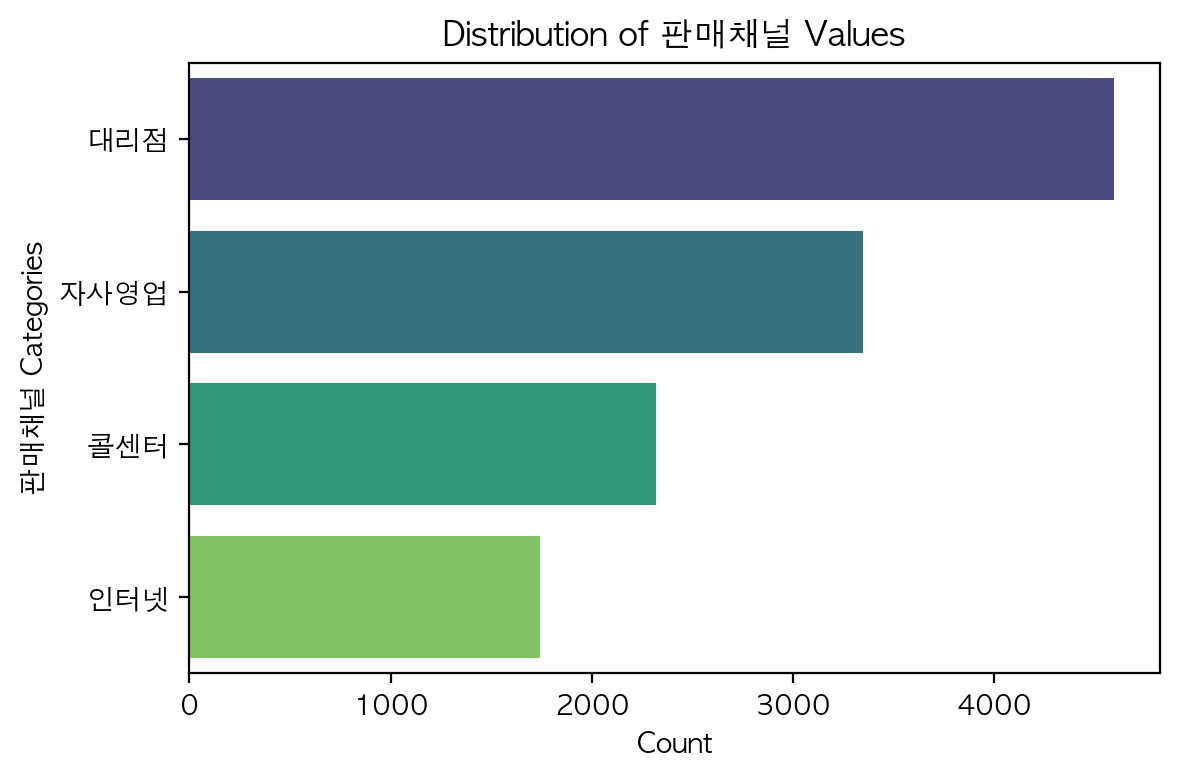

In [14]:
sales_channel = df['판매채널']

plt.figure(figsize=(6, 4))

sns.countplot(y=sales_channel, order=sales_channel.value_counts().index, palette="viridis")
plt.title('Distribution of 판매채널 Values')
plt.xlabel('Count')
plt.ylabel('판매채널 Categories')
plt.tight_layout()
plt.show()

In [15]:
df.columns

Index(['clust', 'AGE', '등록(계/피)', '고용상태', '성별', 'Willingness to pay/Stay',
       '갱신', '상품타입', '교육수준', '소득', '지역', '결혼여부', '월 납입액', 'VOC', '타 상품 보유 현황',
       '온라인방문빈도', '갱신인센티브', '판매채널', '총지불금액', '자동차', '거주지사이즈'],
      dtype='object')

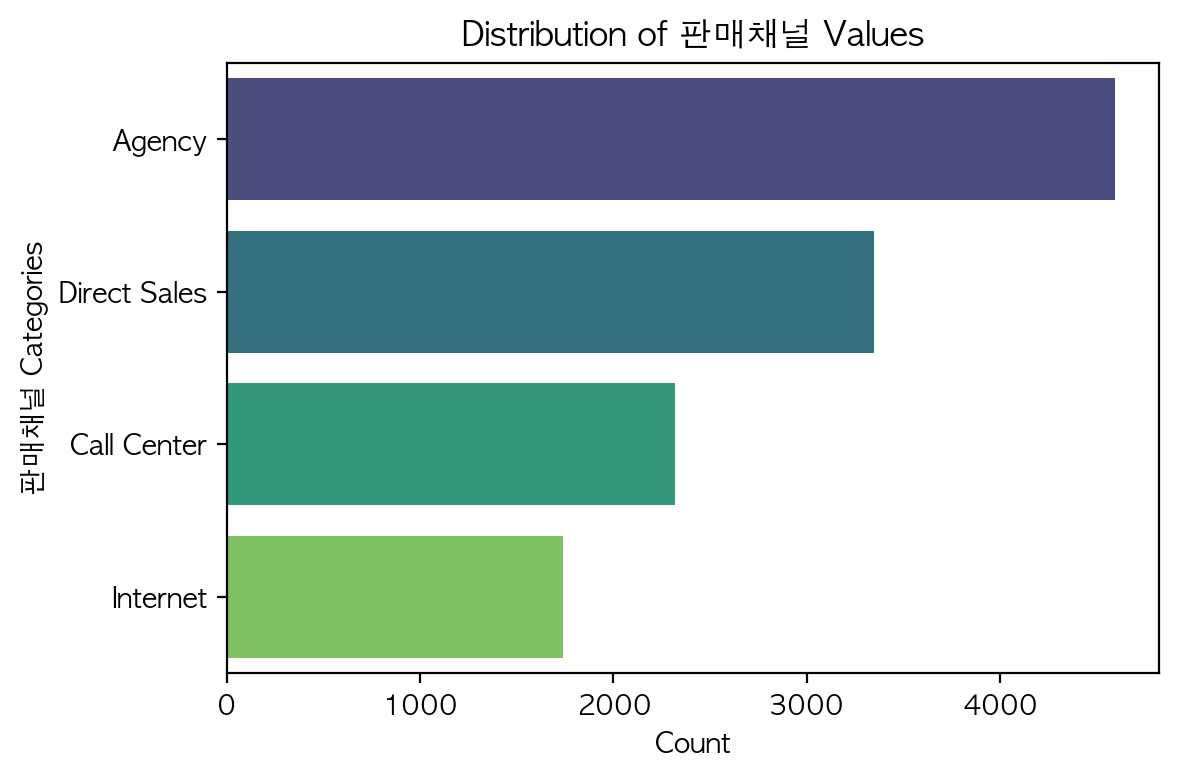

In [16]:
# Define a mapping for "판매채널" categories from Korean to English
sales_channel_mapping = {
    '자사영업': 'Direct Sales',
    '인터넷': 'Internet',
    '대리점': 'Agency',
    '콜센터': 'Call Center'
}

# Map the "판매채널" values to English
sales_channel_english = sales_channel.map(sales_channel_mapping)

# Set up the matplotlib figure
plt.figure(figsize=(6, 4))

# Draw a count plot of mapped "판매채널" values
sns.countplot(y=sales_channel_english, order=sales_channel_english.value_counts().index, palette="viridis")
plt.title('Distribution of 판매채널 Values')
plt.xlabel('Count')
plt.ylabel('판매채널 Categories')
plt.tight_layout()
plt.show()

### `판매채널` 별로 각 변수의 평균값 차이를 확인

- 전체 데이터와의 차이
    - `콜센터`와 `인터넷` 채널을 통한 고객들의 특성이 전체 데이터셋의 평균과 어떻게 다른지를 파악할 수 있다.
    - 이 차이는 특정 채널에 특화된 마케팅 전략이나 제품 전략을 세우는 데 도움이 될 수 있습니다.
- 채널 별 차이점
    - `Willingness to pay/Stay`
        - `콜센터`를 통한 고객들은 전체 평균보다 약 14.4% 높은 결제 의향이 있으며, `인터넷`을 통한 고객들은 약 33.7% 낮은 결제 의향을 보인다.
        - `콜센터`를 통해 연락하는 고객들이 상품에 대한 더 높은 흥미나 만족도를 가질 수 있음을 나타낼 수 있다.
    - `소득`
        - `콜센터`를 통한 고객들의 평균 소득은 전체 평균보다 약 834,299원 높으며, `인터넷`을 통한 고객들의 평균 소득은 약 785,591원 높다.
    - `월 납입액`
        - `콜센터`를 통한 고객들의 평균 월 납입액은 전체 평균보다 약 449.6원 낮으며, `인터넷`을 통한 고객들의 평균 월 납입액은 약 916.4원 낮다.
- 특정 채널의 특성
    - `판매채널_콜센터`
        - `콜센터`를 통한 고객들은 전체 평균보다 약 80.7% 높은 비율을 차지하며, "인터넷"을 통한 고객들은 이 비율이 약 19.3% 낮다.
        - 이는 `콜센터`를 통해 연락하는 고객들이 데이터셋에서 상대적으로 더 많다는 것을 의미한다.

이러한 인사이트는 마케팅 전략, 고객 서비스 전략, 상품 타겟팅 전략 등을 결정하는 데 도움을 줄 수 있다.  
하지만, 이러한 분석만으로는 구체적인 전략을 결정하기에는 부족할 수 있으므로, 추가적인 깊은 분석과 다른 변수들과의 관계, 시간에 따른 변화 등을 고려해야 한다.

In [17]:
# 전체 데이터셋의 평균값 계산: data_encoded의 모든 컬럼에 대한 평균값을 계산
overall_mean = data_encoded.mean()

# "콜센터"와 "인터넷" 부분집합의 평균값 계산: "판매채널"이 "콜센터" 또는 "인터넷"인 데이터의 부분집합에 대한 각 컬럼의 평균값을 계산
call_center_mean = data_encoded[data_encoded['판매채널_콜센터'] == 1].mean()
internet_mean = data_encoded[data_encoded['판매채널_인터넷'] == 1].mean()

# 평균값 비교를 위한 DataFrame 생성: 전체 데이터셋의 평균값과 "콜센터", "인터넷" 부분집합의 평균값을 비교하기 위한 DataFrame을 생성
comparison_df = pd.DataFrame({
    'Overall': overall_mean,
    'Call Center': call_center_mean,
    'Internet': internet_mean
})

# 부분집합과 전체 데이터셋 간의 평균값 차이 계산: "콜센터"와 "인터넷" 부분집합의 각 컬럼의 평균값과 전체 데이터셋의 평균값과의 차이를 계산
comparison_df['Call Center Difference'] = comparison_df['Call Center'] - comparison_df['Overall']
comparison_df['Internet Difference'] = comparison_df['Internet'] - comparison_df['Overall']

comparison_df[['Call Center Difference', 'Internet Difference']]

,Call Center Difference,Internet Difference
clust,0.058426,0.019560
AGE,-0.186292,-0.244023
성별,-0.006773,-0.032986
Willingness to pay/Stay,0.143628,-0.337178
갱신,-0.033901,-0.023460
소득,834299.473846,785591.770690
월 납입액,-449.619448,-916.408046
VOC,0.004400,-0.004534
타 상품 보유 현황,0.038685,0.012103
총지불금액,-2610.427447,-2104.956897


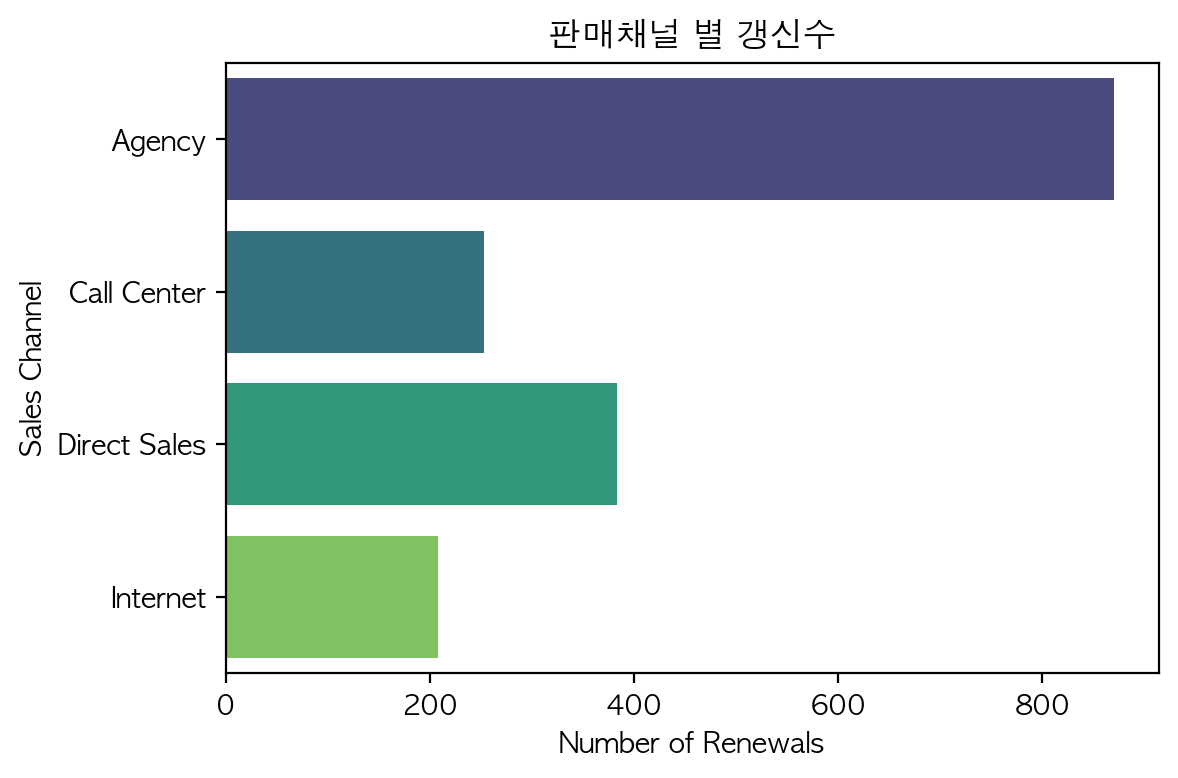

In [18]:
# 판매채널별 갱신수
# Extract the "갱신" column and the original "판매채널" column from the non-encoded data
renewal_data = df[['판매채널', '갱신']].copy()

# Map the "판매채널" values to English
renewal_data['판매채널'] = renewal_data['판매채널'].map(sales_channel_mapping)

# Group by "판매채널" and sum the "갱신" values to get the number of renewals in each sales channel
renewal_counts = renewal_data.groupby('판매채널')['갱신'].sum().reset_index()

# Set up the matplotlib figure
plt.figure(figsize=(6, 4))

# Draw a bar plot of renewal counts in each sales channel
sns.barplot(x='갱신', y='판매채널', data=renewal_counts, palette='viridis')
plt.title('판매채널 별 갱신수')
plt.xlabel('Number of Renewals')
plt.ylabel('Sales Channel')
plt.tight_layout()
plt.show()

## 판매채널별 갱신수에 따른 보험유지 기대확률 분석


### 1. LinearRegression

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 특성과 목표 변수 추출
X = data_encoded.drop(columns=['Willingness to pay/Stay'])
y = data_encoded['Willingness to pay/Stay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# R^2 점수와 평균 제곱 오차(MSE)를 계산하여 모델 성능 평가
r2 = r2_score(y_test, y_pred)               # 결정 계수 R^2
mse = mean_squared_error(y_test, y_pred)    # 평균 제곱 오차

r2, mse

(0.20950372317688815, 47.01019499197556)

- `r2_score`: 0.21 → 그다지 성능이 좋지 못함
- `mean_squared_error`: 47 → 실제 값과 예측 값 사이의 차이가 큼

### 2. RandomForest

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Initialize the StandardScaler
scaler = StandardScaler()

# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Create a pipeline with the scaler and the model
pipeline = Pipeline([('scaler', scaler), ('model', rf_model)])

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = pipeline.predict(X_test)

# Calculate the R^2 score and the Mean Squared Error (MSE) to evaluate the model performance
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

r2_rf, mse_rf

(0.7706969797194319, 13.636471178536066)

- `r2_score`: 0.77 → 성능 좋음
- `mean_squared_error`: 13.6 → 쓸만함

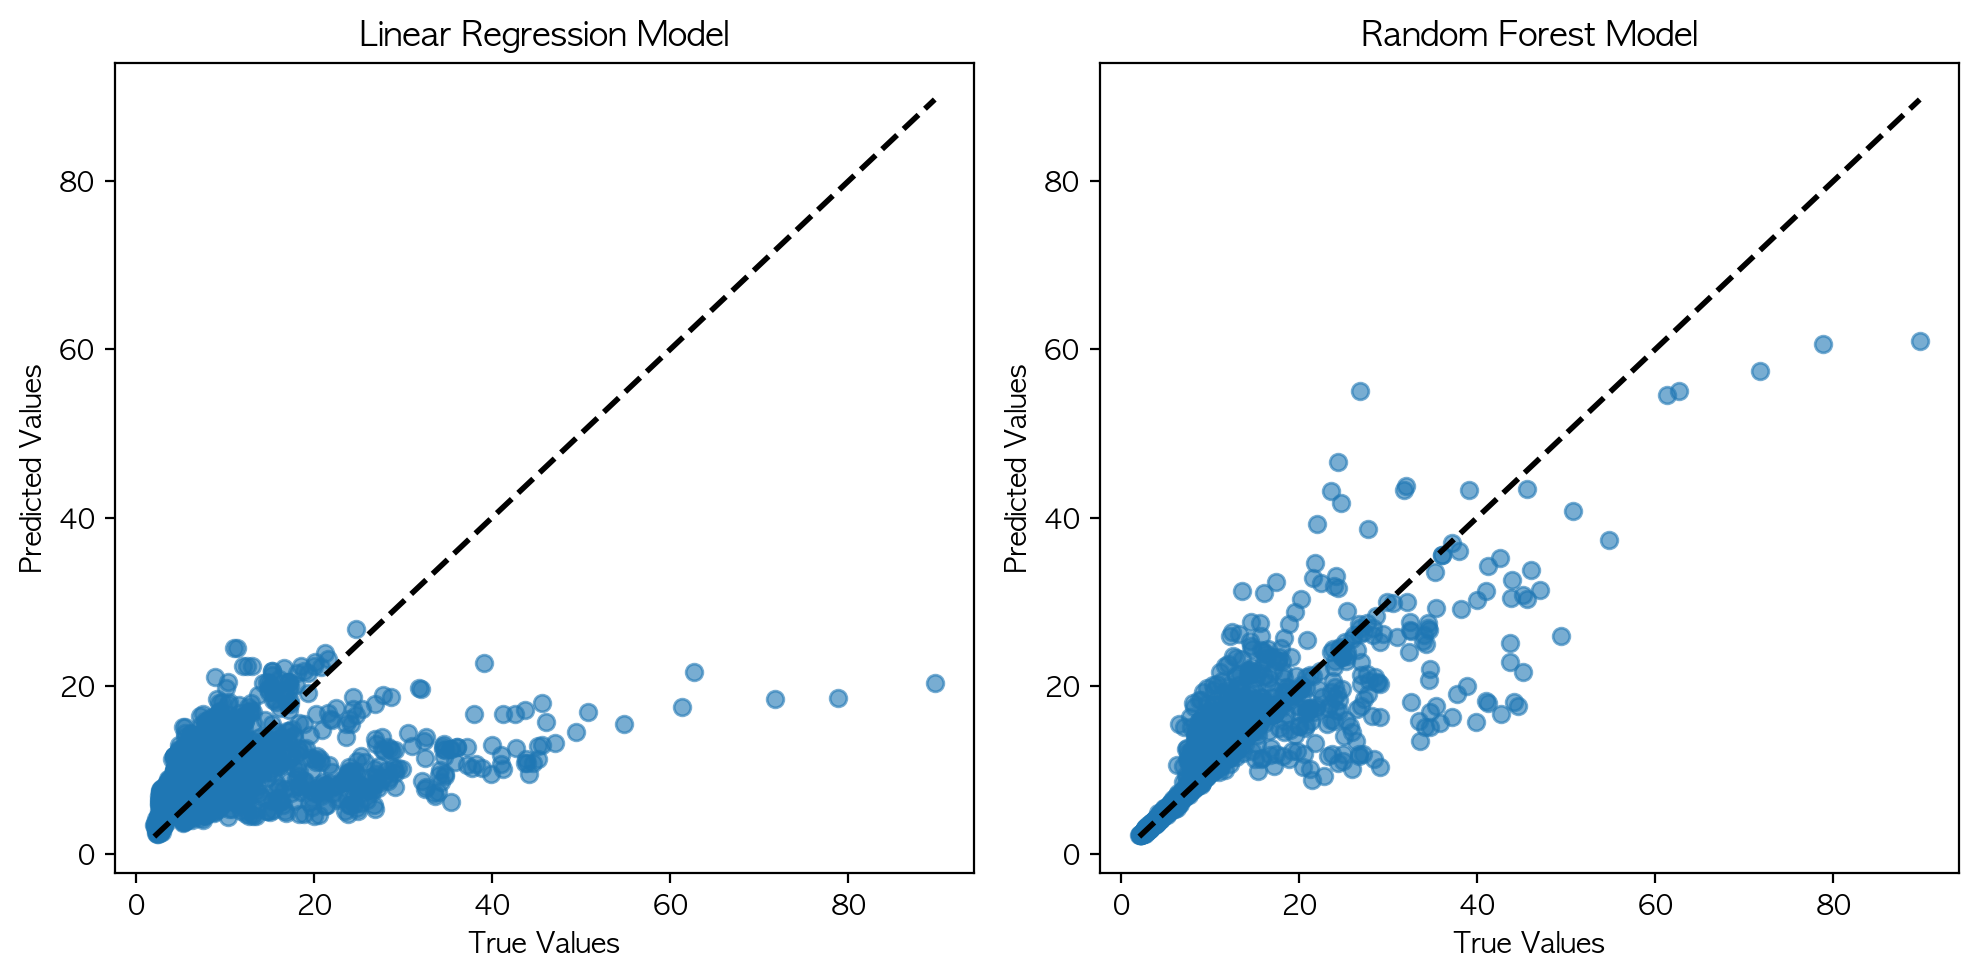

In [21]:
plt.figure(figsize=(10, 5))

# Linear Regression
plt.subplot(121)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Linear Regression Model')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Random Forest
plt.subplot(122)
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Random Forest Model')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()